# Ensemble model
0.5 m1 + 0.5 m2

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [2]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "4.2.0 - ensemble 3.2.0.b"

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading models

In [3]:
# Loding the model

def load_model(model_file):
    """Load the dump model."""
    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [6]:
# model 2
model2_id = "3.2.0 - only invest with zone groups recall"
path_to_save = f"models/{model2_id}/"
model_file = os.path.join(path_to_save, f"{model2_id}.pickle")
columns_file = os.path.join(path_to_save, f"{model2_id} (COLUMNS) - n_features_40.pickle")

m2 = load_model(model_file)
columns2 = load_columns(columns_file)
print(len(columns2))

40


In [7]:
# Loding the model

def load_model3(file_name):
    """Load the dump model."""
    folder = "models"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    model_file = os.path.join(path_to_load, file_name)

    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns3(file_name):
    """Load the array of columns use in the dump model."""
    folder = "features"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    columns_file = os.path.join(path_to_load, file_name)

    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [8]:
model_name = "1.1.b.2.f(Model) - Model Optimization recall - class_weight (1, 18) - time sorted - valid score (0.403, 0.972).pickle"
columns_name = "1.1.b.2.f (COLUMNS) - features: 17.pickle"
m3 = load_model3(model_name)
columns3 = load_columns3(columns_name)

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.21.2. This might lea

## Loading val set

In [9]:
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [10]:
pd.crosstab(df_val["TIPO_EXPED"], [df_val["EXISTE_FRAUDE"], df_val["total_condicion"] > 4], margins=True)

EXISTE_FRAUDE    False       True         All
total_condicion  False True False True       
TIPO_EXPED                                   
0                  388    3     2    0    393
1                 5310   36     7    0   5353
2                30889    6     3    0  30898
3                28171    0     4    0  28175
4                  933    0     1    0    934
5                  672  232    18    5    927
6                 4503  360    76  194   5133
All              70866  637   111  199  71813

In [11]:
X_test = df_val.drop(columns="EXISTE_FRAUDE")
y_test = df_val["EXISTE_FRAUDE"]

In [13]:
# model 2
y_pred_2 = m2.predict_proba(X_test[columns2])[:, 1]

In [14]:
# model 3
y_pred_3 = m3.predict_proba(X_test[columns3])[:, 1]

In [15]:
y_pred = ( y_pred_2 + y_pred_3) / 2

0.239, 0.948


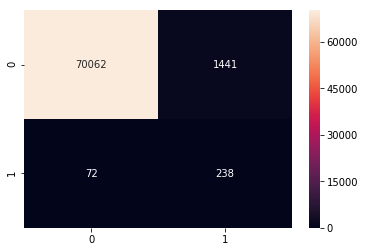

In [16]:
print("%.3f, %.3f" % (f1_score(y_test, y_pred > 0.5), roc_auc_score(y_test, y_pred)))
conf_mat = confusion_matrix(y_test, (y_pred > 0.5))
sns.heatmap(conf_mat, annot=True, fmt="d")

In [17]:
tmp = df_val.copy()
tmp["y_pred"] = y_pred
# tmp = tmp[tmp.total_condicion >= 3]
# tmp = tmp[tmp.TIPO_EXPED >= 4]

pd.crosstab([tmp["TIPO_EXPED"], tmp["total_condicion"]>4], [tmp["EXISTE_FRAUDE"], tmp["y_pred"] > 0.5]) # 

EXISTE_FRAUDE               False       True       
y_pred                      False True  False True 
TIPO_EXPED total_condicion                         
0          False              388     0     2     0
           True                 3     0     0     0
1          False             5310     0     7     0
           True                36     0     0     0
2          False            30889     0     3     0
           True                 6     0     0     0
3          False            28171     0     4     0
4          False              933     0     1     0
5          False              662    10    18     0
           True               226     6     4     1
6          False             3438  1065    33    43
           True                 0   360     0   194

0.347, 0.817


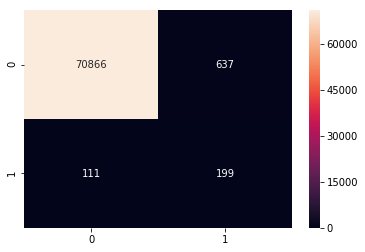

In [18]:
y_tronador = df_val["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

0.239, 0.948


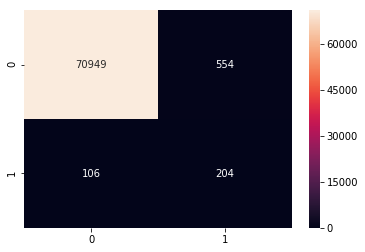

In [19]:
# limit total cond
print("%.3f, %.3f" % (f1_score(y_test, y_pred > 0.5), roc_auc_score(y_test, y_pred)))
conf_mat = confusion_matrix(y_test, ((y_pred > 0.5) & (df_val.total_condicion >= 3)))
sns.heatmap(conf_mat, annot=True, fmt="d")

In [20]:
tmp = df_val.copy()
tmp["y_pred"] = y_pred
# tmp = tmp[tmp.total_condicion >= 3]
# tmp = tmp[tmp.TIPO_EXPED >= 4]

pd.crosstab([tmp["TIPO_EXPED"]], [tmp["EXISTE_FRAUDE"], tmp["y_pred"] > 0.5]) # , tmp["total_condicion"]

EXISTE_FRAUDE  False       True       
y_pred         False True  False True 
TIPO_EXPED                            
0                391     0     2     0
1               5346     0     7     0
2              30895     0     3     0
3              28171     0     4     0
4                933     0     1     0
5                888    16    22     1
6               3438  1425    33   237

## Loading test set

In [21]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [22]:
pd.crosstab(df_test["TIPO_EXPED"], [df_test["EXISTE_FRAUDE"], df_test["total_condicion"]])

EXISTE_FRAUDE    False                                                     \
total_condicion   0.0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  10.0 12.0   
TIPO_EXPED                                                                  
0                   42    94   18    4    3    2    0    0    0    0    0   
1                  804  1372  221  141   54    3    6    2    0    0    0   
2                13953  1768   77  255   40    1    0    0    0    0    0   
3                11098  1014   18  361   33    1    0    0    0    0    0   
4                  367    59    0    7    0    0    0    0    0    0    0   
5                    0     0    0  249   26   75   17    1    4    0    0   
6                 1595   134  239  251   17   80   23    3   15   11    2   

EXISTE_FRAUDE             True                                                \
total_condicion 13.0 15.0  0.0  1.0  2.0  3.0  5.0  6.0  7.0  8.0  9.0  10.0   
TIPO_EXPED                                                                     
0                  0    0     0    0    0    0    0    0    0    0    0    0   
1                  0    0     0    0    0    0    0    0    0    0    0    0   
2                  0    0     0    0    0    0    0    0    0    0    0    0   
3                  0    0     1    0    0    0    0    0    0    0    0    0   
4                  0    0     0    0    0    0    0    0    0    0    0    0   
5                  0    0     0    0    0    5    5    0    0    0    0    0   
6                  1    1    10    1    1   10   30    5    3    6    1    8   

EXISTE_FRAUDE                   
total_condicion 11.0 12.0 13.0  
TIPO_EXPED                      
0                  0    0    0  
1                  0    0    0  
2                  0    0    0  
3                  0    0    0  
4                  0    0    0  
5                  0    0    0  
6                  1    5    4

In [23]:
X_test = df_test.drop(columns="EXISTE_FRAUDE")
y_test = df_test["EXISTE_FRAUDE"]

### Pred model 1

In [24]:
y_pred_2 = m2.predict_proba(X_test[columns2])[:, 1]

### Pred model 2

In [25]:
# model 3
y_pred_3 = m3.predict_proba(X_test[columns3])[:, 1]

## making ensemble pred

In [26]:
# ensemble pred
y_pred = ( y_pred_2 + y_pred_3) / 2

0.189, 0.986


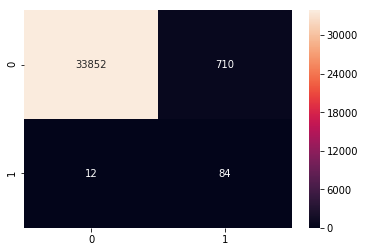

In [27]:
print("%.3f, %.3f" % (f1_score(y_test, y_pred > 0.5), roc_auc_score(y_test, y_pred)))
conf_mat = confusion_matrix(y_test, (y_pred > 0.5))
sns.heatmap(conf_mat, annot=True, fmt="d")

**tronador**

0.330, 0.851


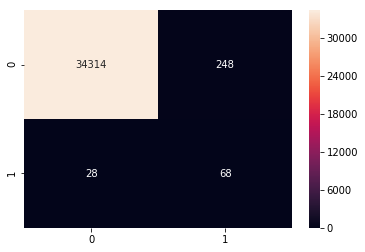

In [28]:
y_tronador = df_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

### distrib

In [29]:
pd.crosstab(df_test["TIPO_EXPED"], [df_test["EXISTE_FRAUDE"], y_pred > 0.5])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                163     0     0     0
1               2603     0     0     0
2              16094     0     0     0
3              12525     0     1     0
4                433     0     0     0
5                363     9     5     5
6               1671   701     6    79

In [30]:
pd.crosstab(df_test["es_gte_5"], [df_test["EXISTE_FRAUDE"], y_pred > 0.5])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
es_gte_5                              
False          33743   571     8    20
True             109   139     4    64

# limitando el total_condicion

0.189, 0.986


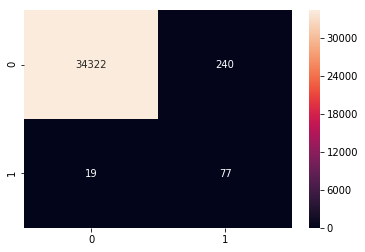

In [31]:
print("%.3f, %.3f" % (f1_score(y_test, y_pred > 0.5), roc_auc_score(y_test, y_pred)))
conf_mat = confusion_matrix(y_test, ((y_pred > 0.5) & (df_test.total_condicion >= 3)))
sns.heatmap(conf_mat, annot=True, fmt="d")

In [32]:
tmp = df_test.copy()
tmp["y_pred"] = y_pred
tmp = tmp[tmp.total_condicion >= 3]

pd.crosstab([tmp["es_gte_5"], tmp["TIPO_EXPED"]], [tmp["EXISTE_FRAUDE"], tmp["y_pred"] > 0.5])

EXISTE_FRAUDE       False       True       
y_pred              False True  False True 
es_gte_5 TIPO_EXPED                        
False    0              7     0     0     0
         1            195     0     0     0
         2            295     0     0     0
         3            394     0     0     0
         4              7     0     0     0
         5            269     6     1     4
         6            173    95     1     9
True     0              2     0     0     0
         1             11     0     0     0
         2              1     0     0     0
         3              1     0     0     0
         5             94     3     4     1
         6              0   136     0    63